In [4]:
import numpy as np
import torch
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from plot_utils import adjust_spines

# the simulator
import simulator

# sbi
import sbi.utils as utils

# ephys extraction utilities
from ephys_utils import get_time_voltage_current_currindex0, calculate_summary_statistics, syn_current

# load and read nwb files
from pynwb import NWBHDF5IO

# import saver utilities
import pickle

# to check how long things take
import time

In [5]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Loading observed experimental data

In [7]:
M1_25degree = pickle.load(open('pickles/M1_features.pickle', 'rb'))
ephys_features = np.array(M1_25degree['X_o'].columns)[:-4]
Xo = M1_25degree['X_o'].copy()

In [8]:
prop = pd.read_csv('../data/m1_patchseq_meta_data.csv', sep = '\t')
prop = prop.rename(columns = {'Targeted layer': 'Layer'})
prop = prop[['Cell', 'Layer', 'Cre', 'RNA type']]
prop = prop.set_index('Cell')
prop=prop.reindex(Xo.index)
no_low_qual=np.array(list(map(str,prop['RNA type'].values)))!='nan'
prop=prop.loc[no_low_qual,:]
Xo = Xo.loc[no_low_qual,:]
celltypes=prop['RNA type']

## The uniform prior

In [14]:
model_param_names = np.array(['C', r'$R_{input}$', r'$\tau$', r'$g_{Nat}$', r'$g_{Na}$', r'$g_{Kd}$', r'$g_{M}$',
                         r'$g_{Kv31}$', r'$g_{L}$', r'$E_{leak}$', r'$\tau_{max}$', 'VT', 'rate_to_SS_factor'])
prior_min = [0.1,  20,  0.1,    0,        0,      0,      0,      0,      0, -130,    50,    -90,   0.1]
prior_max = [15,   1000,   70,   250,     100,      30,    3,     250,     3,  -50,  4000,   -35,    3]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min),
    high=torch.as_tensor(prior_max)
)

## The simulator

In [17]:
from simulator import EphysModel

In [19]:
M1_model=EphysModel(name='M1',
                   T=25.0,
                   E_Na=69.0,
                   E_K=-98.4,
                   E_Ca=127.2,
                   start=100,
                   end=700,
                   dt=0.04,
                   n_processes=1,
                   noise_factor=10,
                   use_pathos=False,
                   chunk_size=1000,
                   save_chunks=False)

Let us have a look at two examples.

In [22]:
trial_1=np.array([9.537584,272.991610,21.443249,93.058479,36.266320,10.740511,0.880451,27.365699,
                0.912325,-85.184921,413.258078,-54.367571,1.655731], dtype=float)[np.newaxis,:]
trial_2=np.array([4.6663e+00,  8.8783e+02,  4.7671e+01,  1.9546e+02,  5.8235e+01,
          2.6093e+01,  2.5880e+00,  7.3475e+01,  1.5024e-01, -6.6966e+01,
          1.0466e+03, -7.0326e+01,  1.5891e+00], dtype=float)[np.newaxis,:]
trial = np.concatenate((trial_1,trial_2),axis=0)
x=M1_model._run_HH_model(trial)

In [23]:
x['data'].shape

(2, 1, 20000)

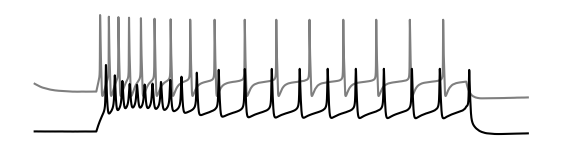

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(7, 1.7))
ax.plot(x['time'], x['data'][0,0,:], c='k')
ax.plot(x['time'], x['data'][1,0,:]+70, c='k', alpha=0.5)
sns.despine(left=True, bottom=True, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(
    "../figures/preliminary/simulations_example.png", bbox_inches="tight", pad_inches=0, dpi=500
)

In [25]:
df=pd.DataFrame(data=M1_model._simulation_wrapper(trial).numpy(), columns=ephys_features)
df.head()

INFO       Overwriting environment variable "DYLD_LIBRARY_PATH" [brian2.devices.cpp_standalone.device.overwritten_env_var]


,AP threshold,AP amplitude,AP width,AHP,3rd AP threshold,3rd AP amplitude,3rd AP width,3rd AHP,AP count,AP count 1st 8th,...,AP amp adapt,AP average amp adapt,AP CV,ISI adapt,ISI CV,latency,rest $V_{m}$ mean,$V_{m}$ mean,$V_{m}$ std,$V_{m}$ skewness
0,-51.738207,89.468064,1.96,-0.318251,-41.161519,49.197436,2.56,-0.996504,3.135494,2.197225,...,-0.358867,0.433474,-1.441896,-0.178451,-0.651787,2.447551,-85.335562,-43.962411,293.426812,2.116857
1,-51.267829,111.434644,1.04,-38.299736,-50.674614,106.787873,0.96,-38.848888,2.944439,2.079442,...,-0.036859,0.424620,-3.586098,0.080907,-0.838951,1.729884,-79.066242,-63.654165,394.178454,3.166713


Let's try out a randomly sampled one from our uniform prior. It could be a simulation with no action potentials and/or look quite weird!

In [31]:
trial=prior.sample((1,))
df=pd.DataFrame(data=trial,columns=model_param_names)
x=M1_model._run_HH_model(trial)
df.head()

,C,$R_{input}$,$\tau$,$g_{Nat}$,$g_{Na}$,$g_{Kd}$,$g_{M}$,$g_{Kv31}$,$g_{L}$,$E_{leak}$,$\tau_{max}$,VT,rate_to_SS_factor
0,1.815982,683.523254,41.196461,124.951691,68.359253,6.551626,2.951238,83.957047,1.288188,-124.523758,732.088196,-37.724304,0.876915


Text(0, 0.5, 'mV')

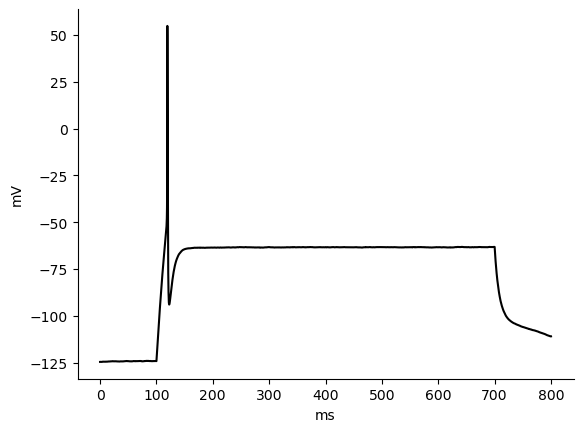

In [33]:
plt.plot(x['time'], x['data'][0,0,:], c='k')
plt.xlabel('ms')
plt.ylabel('mV')

In [35]:
df=pd.DataFrame(data=M1_model._simulation_wrapper(trial).numpy(), columns=ephys_features)
df.head()

,AP threshold,AP amplitude,AP width,AHP,3rd AP threshold,3rd AP amplitude,3rd AP width,3rd AHP,AP count,AP count 1st 8th,...,AP amp adapt,AP average amp adapt,AP CV,ISI adapt,ISI CV,latency,rest $V_{m}$ mean,$V_{m}$ mean,$V_{m}$ std,$V_{m}$ skewness
0,-45.985126,100.85592,0.84,-47.927654,NaN,NaN,NaN,NaN,1.386294,1.386294,...,NaN,NaN,NaN,NaN,NaN,2.942331,-124.200186,-64.345006,52.430851,0.420651


## Simulate

In [20]:
M1_model=EphysModel(name='M1',
                   T=25.0,
                   E_Na=69.0,
                   E_K=-98.4,
                   E_Ca=127.2,
                   start=100,
                   end=700,
                   dt=0.04,
                   n_processes=40,
                   noise_factor=10,
                   use_pathos=True,
                   chunk_size=50000,
                   save_chunks=True)

In [ ]:
t = time.time()
n_samples = int(15*1e6)
theta = prior.sample((n_samples,))
M1_model.sim(theta)
np.savez('./save_sims/M1_chunks/full_batch.npz',
     theta=M1_model.theta.numpy(),
     stats=M1_model.stats.numpy()
    )
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('\nTime: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

Chunks:
.........10.........20

## Distribution of summary statistics

Let us have a look at the distribion of simulated summary statistics (or ephys features) versus the distribution of summary statistics of our observed experimental dataset.

In [40]:
# In our visualizations of 1-dimensional ephys feature distributions,
# we'll keep the ones within certain limits to prevent outliers in the visualization.
limits={'AP threshold':[-120,75], 'AP amplitude':[0,200], 'AP width':[0,5], 'AHP':[-80,50], \
        '3rd AP threshold':[-100,100], '3rd AP amplitude':[0,200], '3rd AP width':[0,5], '3rd AHP':[-60,30], \
        'AP count':[0,400], 'AP count 1st 8th': [0,135], 'AP count 1st quarter': [0,180], \
        'AP count 1st half':[0,200], 'AP count 2nd half':[0,200], 'AP amp adapt':[-1.5,1.5], \
        'AP average amp adapt':[-0.1,1.1], 'AP CV':[-7.5,0], \
        'ISI adapt':[-3,3], 'ISI CV':[-8,2.5], 'latency':[-2,6.5], r'rest $V_{m}$ mean':[-120,100], \
        r'$V_{m}$ mean':[-110,50], r'$V_{m}$ std':[0,2000], r'$V_{m}$ skewness':[-2,12], \
        'Vi':[-150,-40], '1-comp area':[0,4000]}

(# sims, # ephys features):  (15000000, 23)
and after deleting Nan and Inf simulations: 
(# sims, # ephys features):  (7155552, 23)


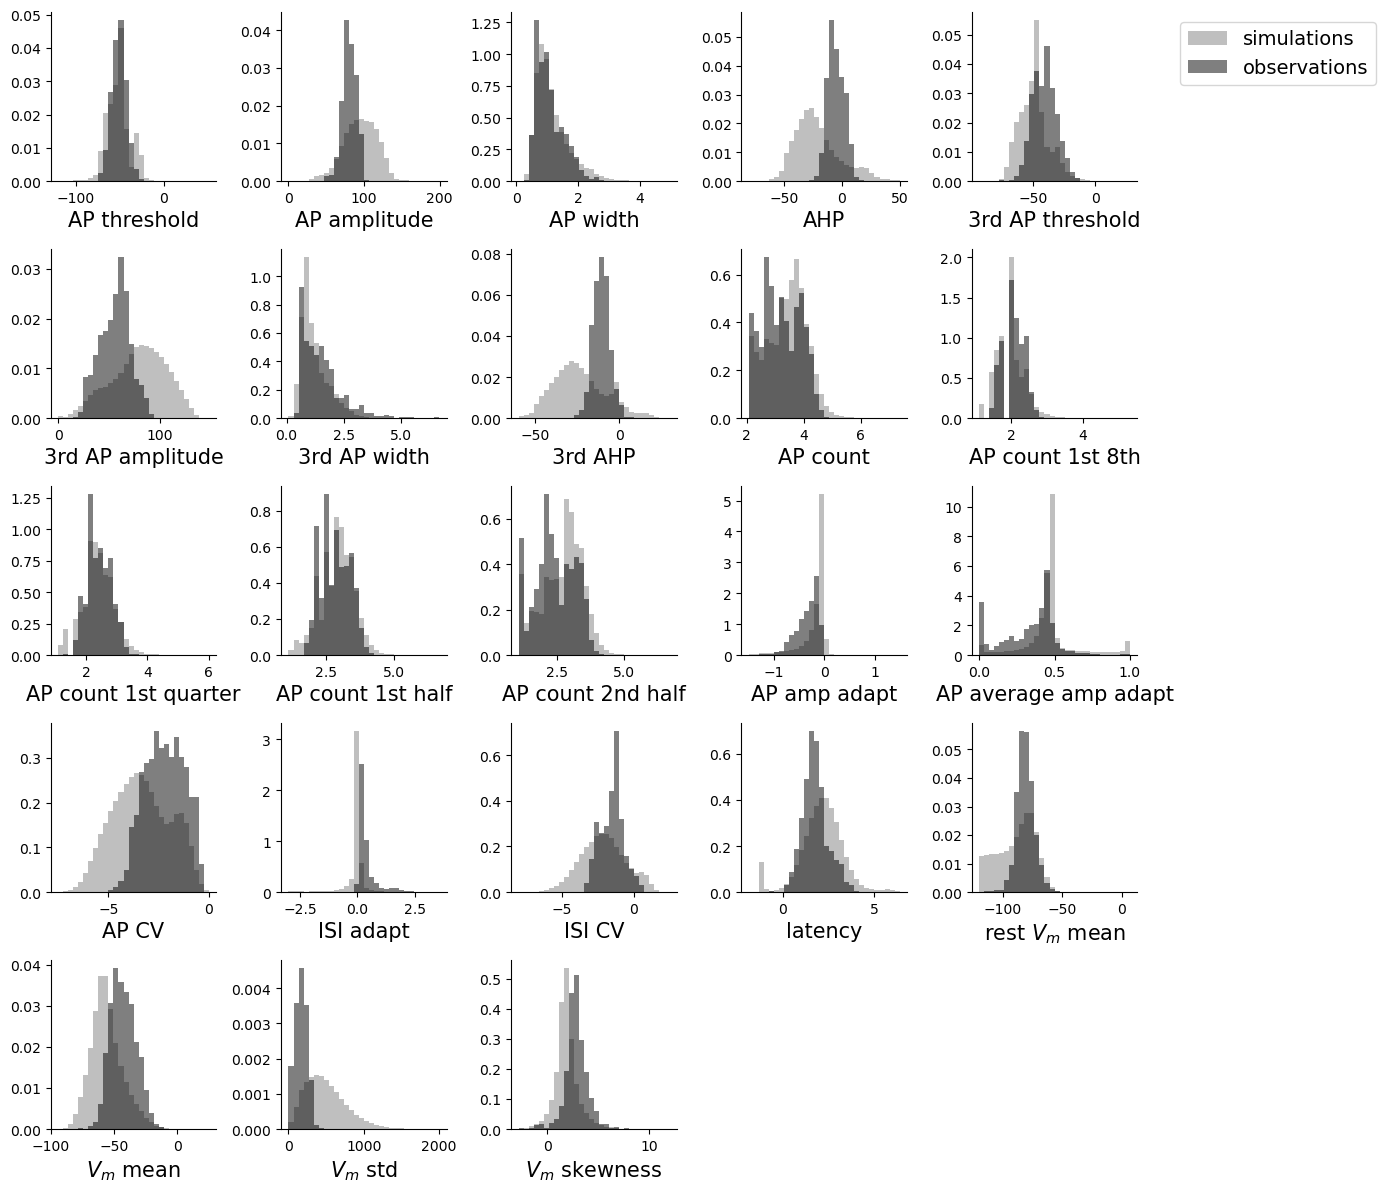

In [42]:
theta=np.load('./save_sims/M1_chunks/full_batch.npz')['theta']
stats=np.load('./save_sims/M1_chunks/full_batch.npz')['stats']
print('(# sims, # ephys features): ', stats.shape)
keeping=(~np.isnan(np.mean(stats, axis=1)))&(~np.isinf(np.mean(stats, axis=1)))
stats = stats[keeping,:] # delete Nan simulations
print('and after deleting Nan and Inf simulations: \n(# sims, # ephys features): ', stats.shape)

fig, axes = plt.subplots(5, 5, figsize = (14, 12))
xlabelfontsize=15
for i, ax in enumerate(axes.reshape(-1)[:len(ephys_features)]):
        ax.hist([Xo[ephys_features[i]].values,
                 stats[:,i][(stats[:,i]>limits[ephys_features[i]][0])&\
                            (stats[:,i]<limits[ephys_features[i]][1])]],
                color=['black', 'grey'], alpha=0.5, bins=30, density=True, histtype='stepfilled', \
                label=[ 'observations', 'simulations'])
        ax.set_xlabel(ephys_features[i], fontsize=xlabelfontsize)
        if i==4:
            ax.legend(fontsize=14, bbox_to_anchor=(1.2, 1))

for ax in axes.reshape(-1)[len(ephys_features):]:
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)
plt.tight_layout()

Most summary statistics of our experimental dataset (observations) are very nicely covered by our simulations. Yet, we can observe the 'simulation gap' in terms of some 'harder to fit' summary statistics, such as the ISI adapt.

## Best prior simulations for some experimental observations

Pick a cell. You can for instance check `Xo.index` and pick one.

In [25]:
cell_name = '20190418_sample_8'
cell_name = '20190418_sample_2'
cell_name = '20200106_sample_1'
cell_name = '20190704_sample_14'
cell_name = '20190722_sample_1'
cell_name = '20190725_sample_3'
cell_name = '20190416_sample_7'

In [27]:
#Check whether raw file name corresponds to the cell's name
data = np.array(M1_25degree['M1_names'])[no_low_qual][np.where(Xo.index==cell_name)[0][0]]
data

'../data/raw_data/000008/sub-mouse-PHFLX/sub-mouse-PHFLX_ses-20190416-sample-7_slice-20190416-slice-7_cell-20190416-sample-7_icephys.nwb'

In [29]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = NWBHDF5IO(data, 'r', load_namespaces=True).read()

In [30]:
xo=Xo.loc[cell_name,:].iloc[:-4].values
feature_list=range(23)

In [31]:
time_obs, voltage_obs, current_obs, curr_index_0_obs = get_time_voltage_current_currindex0(data)
liquid_junction_potential=15.4
voltage_obs-=liquid_junction_potential

I, t_on, t_off, dt, t, A_soma = syn_current(area=Xo.loc[cell_name, '1-comp area'], curr_level=3e-4)
curr_index = np.where(current_obs==300)[0][0]
observation = {'data': voltage_obs[:20000, curr_index], 'time': time_obs[:20000]*1e3, 'dt':4*1e-5*1e3, 'I': I}

WARNING    /Users/yvesbernaerts/Documents/PhD/hh_sbi/code/ephys_utils.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  voltage[:, curr_index_0] = df.iloc[curr_index_0*2][0][0].data[:]    # Find voltage trace for 0 current stimulation
 [py.warnings]


In [38]:
theta=np.load('./save_sims/M1_chunks/full_batch.npz')['theta']
stats=np.load('./save_sims/M1_chunks/full_batch.npz')['stats']
print('(# sims, # ephys features): ', stats.shape)
keeping=(~np.isnan(np.mean(stats, axis=1)))&(~np.isinf(np.mean(stats, axis=1)))
stats = stats[keeping,:] # delete Nan simulations
print('and after deleting Nan and Inf simulations: \n(# sims, # ephys features): ', stats.shape)

(# sims, # ephys features):  (15000000, 23)
and after deleting Nan and Inf simulations: 
(# sims, # ephys features):  (7155552, 23)


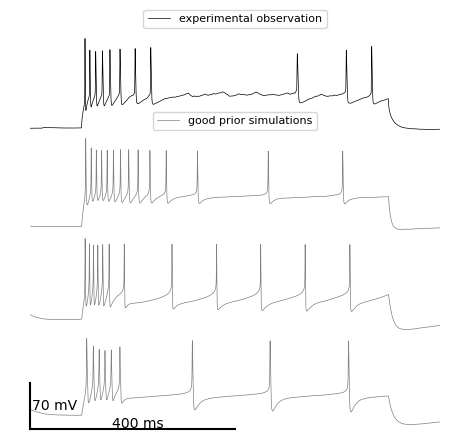

In [40]:
# Best Euclidean examples now for an example
fig=plt.figure(figsize=(5,5))
width=.9
height=.2
ax_truth=plt.axes([0,0.6,width,height])
ax_sim1=plt.axes([0,0.4,width,height])
ax_sim2=plt.axes([0,.2,width,height])
ax_sim3=plt.axes([0,0,width,height])

# plot observation
ax_truth.plot(observation['time'], observation['data'], lw=.5, label='experimental observation', c='k')
ax_truth.legend(loc='upper center', bbox_to_anchor=(.5,1.3), fontsize=8)
ax_truth.set_xticks([])
ax_truth.set_yticks([])
sns.despine(ax=ax_truth, bottom=True,left=True)

#3. pick 3 that have the smallest Euclidean distance of their summ stats with the experimental observation
s_mean=stats[:,feature_list].mean(axis=0)
s_std=stats[:,feature_list].std(axis=0)
ind=np.argsort(np.sum(
                np.square((stats[:,feature_list]-s_mean)/s_std
                    -(xo[feature_list]-s_mean)/s_std
                         ),
                axis=1
                    )
              )[0:3]
#4. show those 3 simulations
x = M1_model._run_HH_model(theta[keeping,:][ind,:])
ax_sim1.plot(x['time'], x['data'][0,0,:], lw=.5, c='grey', label='good prior simulations')
ax_sim2.plot(x['time'], x['data'][1,0,:], lw=.5, c='grey')
ax_sim3.plot(x['time'], x['data'][2,0,:], lw=.5, c='grey')
ax_sim3.plot([0,400], [-95,-95], 'k')
ax_sim3.annotate('400 ms', (160,-92))
ax_sim3.plot([0,0], [-95,-25], 'k')
ax_sim3.annotate('70 mV', (3,-65))
# ax_sim3.set_xlabel('Time (ms)', fontsize=10)
# ax_sim3.set_ylabel('Voltage (mV)', fontsize=10)
ax_sim1.legend(loc='upper center', bbox_to_anchor=(.5,1.28), fontsize=8)
for ax in [ax_truth, ax_sim1, ax_sim2, ax_sim3]:
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True,left=True)

In [42]:
df=pd.DataFrame(data=theta[keeping,:][ind,:], columns=model_param_names)
df

,C,$R_{input}$,$\tau$,$g_{Nat}$,$g_{Na}$,$g_{Kd}$,$g_{M}$,$g_{Kv31}$,$g_{L}$,$E_{leak}$,$\tau_{max}$,VT,rate_to_SS_factor
0,12.123706,187.359436,6.432024,94.827339,62.489391,12.678920,2.721592,48.442440,0.354154,-82.102066,425.749237,-52.919109,0.346996
1,9.238253,487.687927,25.799484,67.786186,75.268784,22.884243,2.182982,53.657578,2.875504,-65.171471,335.421448,-41.164742,0.550396
2,5.769298,672.901733,42.560696,14.885798,46.886562,19.505648,1.149425,36.238388,2.065062,-64.805290,405.157806,-46.957733,1.673298
